In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=25

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "DiseasesDataset",
    shuffle = True,
    seed=123,
    image_size = (294,222),
    batch_size = BATCH_SIZE
)

Found 6060 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['1. Eczema',
 '2. Melanoma',
 '3. Atopic Dermatitis',
 '4. Basal Cell Carcinoma',
 '5. Melanocytic Nevi',
 '6. Benign Keratosis']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(294, 222, 3)


In [7]:
len(dataset)

190

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
    

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

152

In [11]:
len(val_ds)

19

In [12]:
len(test_ds)

19

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(294, 222),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, 294, 222, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(6,activation='softmax'),    
])

model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10
152/152 [==============================] - 253s 2s/step - loss: 1.2818 - accuracy: 0.4595 - val_loss: 1.1294 - val_accuracy: 0.5082
Epoch 2/10
152/152 [==============================] - 243s 2s/step - loss: 1.0953 - accuracy: 0.5351 - val_loss: 1.1793 - val_accuracy: 0.4753
Epoch 3/10
152/152 [==============================] - 236s 2s/step - loss: 1.0326 - accuracy: 0.5547 - val_loss: 1.0575 - val_accuracy: 0.5510
Epoch 4/10
152/152 [==============================] - 225s 1s/step - loss: 0.9934 - accuracy: 0.5683 - val_loss: 0.9052 - val_accuracy: 0.5954
Epoch 5/10
152/152 [==============================] - 288s 2s/step - loss: 0.9321 - accuracy: 0.5995 - val_loss: 0.9889 - val_accuracy: 0.5757
Epoch 6/10
152/152 [==============================] - 324s 2s/step - loss: 0.9045 - accuracy: 0.6003 - val_loss: 0.8255 - val_accuracy: 0.6480
Epoch 7/10
152/152 [==============================] - 321s 2s/step - loss: 0.8515 - accuracy: 0.6340 - val_loss: 0.8845 - val_accuracy: 0.6102

In [22]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 19s 299ms/step - loss: 0.7429 - accuracy: 0.7303


In [23]:
model.save(f"./trained_model")

INFO:tensorflow:Assets written to: ./trained_model\assets


INFO:tensorflow:Assets written to: ./trained_model\assets


In [27]:
model.save('trial_model.h5')

Image to predict
Image's actual label: 2. Melanoma
1/1 [==============================] - 0s 337ms/step
Predicted:  2. Melanoma


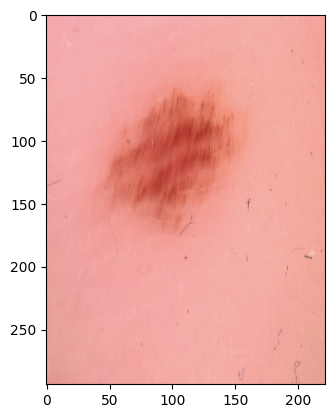

In [29]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    print("Image to predict")
    print("Image's actual label:", class_names[label_batch[0].numpy()])
    batch_prediction = model.predict(image_batch)
    print("Predicted: ",class_names[np.argmax(batch_prediction[0])])
    plt.imshow(image_batch[1].numpy().astype('uint8'))
    